# Mean climate evaluation

This analysis compares the mean climate of downscaled and parent models to observations. It doesn't consider extremes (i.e. the tails of the distribution aren't considered).

In [1]:
import glob
import calendar

import xarray as xr
import numpy as np
import xesmf as xe
import dask.diagnostics
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import geopandas as gp
from geocat.viz import TaylorDiagram
import cmocean

import spatial_selection

/g/data/xv83/dbi599/miniconda3/envs/model-eval/lib/python3.10/site-packages/geocat/viz/cmaps.py:9: DeprecationWarning: geocat.viz.cmaps is deprecated, use cmaps instead
  warnings.warn("geocat.viz.cmaps is deprecated, use cmaps instead",


In [2]:
dask.diagnostics.ProgressBar().register()

In [3]:
start_date = '1995-01-01'
end_date = '2014-12-31'

In [4]:
nrm_clusters = gp.read_file('/g/data/xv83/dbi599/shapefiles/NRM_clusters/NRM_clusters.shp')

/g/data/xv83/dbi599/miniconda3/envs/model-eval/lib/python3.10/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/g/data/xv83/dbi599/miniconda3/envs/model-eval/lib/python3.10/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


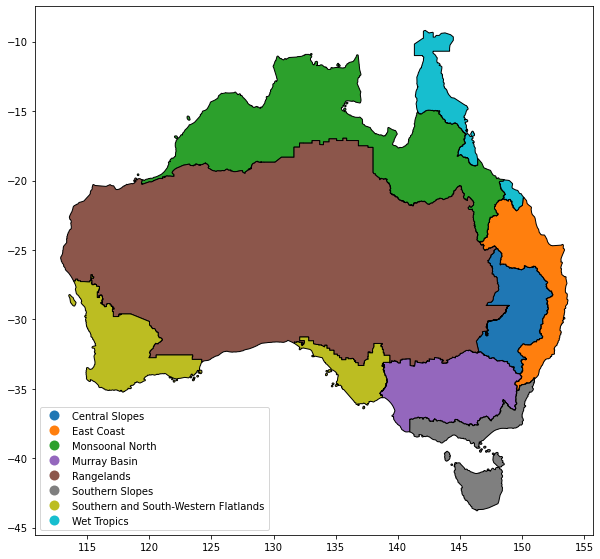

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
nrm_clusters.plot(
    ax=ax,
    column='label',
    legend=True,
    edgecolor='black',
    legend_kwds={'loc': 'lower left'}    
)
plt.show()

In [6]:
nrm_sub_clusters = gp.read_file('/g/data/xv83/dbi599/shapefiles/NRM_sub_clusters/NRM_sub_clusters.shp')

/g/data/xv83/dbi599/miniconda3/envs/model-eval/lib/python3.10/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/g/data/xv83/dbi599/miniconda3/envs/model-eval/lib/python3.10/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


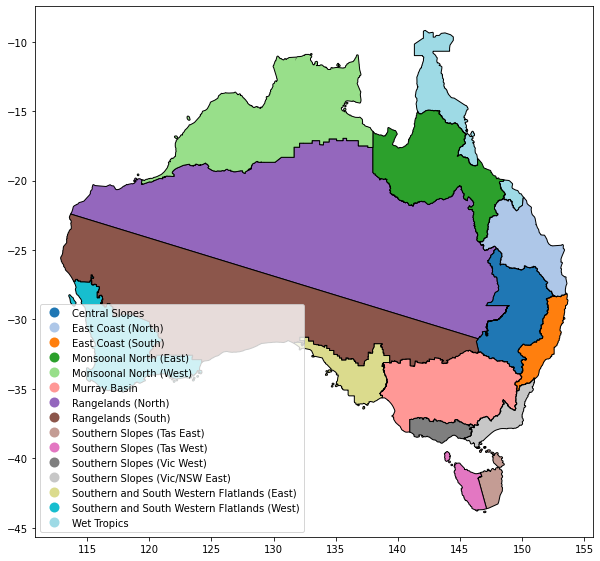

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
nrm_sub_clusters.plot(
    ax=ax,
    column='label',
    legend=True,
    edgecolor='black',
    cmap='tab20',
    legend_kwds={'loc': 'lower left'}    
)
plt.show()

In [8]:
aus_shape = gp.read_file('/g/data/xv83/dbi599/shapefiles/australia/australia.shp')

## Get AGCD data

In [9]:
agcd_years = np.arange(1995, 2015, 1)
agcd_pr_files = [f'/g/data/zv2/agcd/v2/precip/total/r005/01month/agcd_v2_precip_total_r005_monthly_{year}.nc' for year in agcd_years]
agcd_pr_files

['/g/data/zv2/agcd/v2/precip/total/r005/01month/agcd_v2_precip_total_r005_monthly_1995.nc',
 '/g/data/zv2/agcd/v2/precip/total/r005/01month/agcd_v2_precip_total_r005_monthly_1996.nc',
 '/g/data/zv2/agcd/v2/precip/total/r005/01month/agcd_v2_precip_total_r005_monthly_1997.nc',
 '/g/data/zv2/agcd/v2/precip/total/r005/01month/agcd_v2_precip_total_r005_monthly_1998.nc',
 '/g/data/zv2/agcd/v2/precip/total/r005/01month/agcd_v2_precip_total_r005_monthly_1999.nc',
 '/g/data/zv2/agcd/v2/precip/total/r005/01month/agcd_v2_precip_total_r005_monthly_2000.nc',
 '/g/data/zv2/agcd/v2/precip/total/r005/01month/agcd_v2_precip_total_r005_monthly_2001.nc',
 '/g/data/zv2/agcd/v2/precip/total/r005/01month/agcd_v2_precip_total_r005_monthly_2002.nc',
 '/g/data/zv2/agcd/v2/precip/total/r005/01month/agcd_v2_precip_total_r005_monthly_2003.nc',
 '/g/data/zv2/agcd/v2/precip/total/r005/01month/agcd_v2_precip_total_r005_monthly_2004.nc',
 '/g/data/zv2/agcd/v2/precip/total/r005/01month/agcd_v2_precip_total_r005_monthl

In [10]:
agcd_ds = xr.open_mfdataset(agcd_pr_files)
agcd_ds = agcd_ds.sel({'time': slice(start_date, end_date)})

/g/data/xv83/dbi599/miniconda3/envs/model-eval/lib/python3.10/site-packages/xarray/backends/plugins.py:98: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  entrypoints = entry_points().get("xarray.backends", ())


In [11]:
agcd_annual_totals = agcd_ds.resample({'time': 'A'}).sum('time', keep_attrs=True)
agcd_annual_clim = agcd_annual_totals.mean('time', keep_attrs=True)
agcd_monthly_clim = agcd_ds.groupby('time.month').mean('time', keep_attrs=True)

In [12]:
agcd_annual_clim = spatial_selection.select_shapefile_regions(agcd_annual_clim, aus_shape)

[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  5.6s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  3.4s


In [13]:
agcd_monthly_clim = spatial_selection.select_shapefile_regions(agcd_monthly_clim, aus_shape)

[########################################] | 100% Completed |  0.8s
[########################################] | 100% Completed |  0.8s
[########################################] | 100% Completed |  3.6s
[########################################] | 100% Completed |  0.9s
[########################################] | 100% Completed |  1.1s
[########################################] | 100% Completed |  3.7s


## Parent model data

In [14]:
parent_files = {}
parent_files['NorESM2-MM'] = [
    '/g/data/oi10/replicas/CMIP6/CMIP/NCC/NorESM2-MM/historical/r1i1p1f1/day/pr/gn/v20191108/pr_day_NorESM2-MM_historical_r1i1p1f1_gn_19900101-19991231.nc',
    '/g/data/oi10/replicas/CMIP6/CMIP/NCC/NorESM2-MM/historical/r1i1p1f1/day/pr/gn/v20191108/pr_day_NorESM2-MM_historical_r1i1p1f1_gn_20000101-20091231.nc',
    '/g/data/oi10/replicas/CMIP6/CMIP/NCC/NorESM2-MM/historical/r1i1p1f1/day/pr/gn/v20191108/pr_day_NorESM2-MM_historical_r1i1p1f1_gn_20100101-20141231.nc'
]
parent_files['ACCESS-CM2'] = [
    '/g/data/fs38/publications/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/r4i1p1f1/day/pr/gn/latest/pr_day_ACCESS-CM2_historical_r4i1p1f1_gn_19500101-19991231.nc',
    '/g/data/fs38/publications/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/r4i1p1f1/day/pr/gn/latest/pr_day_ACCESS-CM2_historical_r4i1p1f1_gn_20000101-20141231.nc'
]

In [15]:
def read_parent_pr_data(file_list, start_date, end_date, obs_ds, aus_shape):
    """Read parent model precipitation data and calculate annual and monthly climatology"""
    
    ds = xr.open_mfdataset(file_list)
    ds = ds.sel({'time': slice(start_date, end_date)})
    ds['pr'] = ds['pr'] * 86400
    ds['pr'].attrs['units'] = 'mm'
    
    annual_totals = ds.resample({'time': 'A'}).sum('time', keep_attrs=True)
    annual_clim = annual_totals.mean('time', keep_attrs=True)
    monthly_totals = ds.resample({'time': 'M'}).sum('time', keep_attrs=True)
    monthly_clim = monthly_totals.groupby('time.month').mean('time', keep_attrs=True)
    
    regridder = xe.Regridder(ds, obs_ds, "bilinear")
    annual_clim = regridder(annual_clim)
    monthly_clim = regridder(monthly_clim)
    
    annual_clim = spatial_selection.select_shapefile_regions(annual_clim, aus_shape)
    monthly_clim = spatial_selection.select_shapefile_regions(monthly_clim, aus_shape)
    
    annual_clim = annual_clim.compute()
    monthly_clim = monthly_clim.compute()
    
    return monthly_clim, annual_clim

In [16]:
annual_clim_dict = {}
monthly_clim_dict = {}

for model in ['NorESM2-MM', 'ACCESS-CM2']:
    monthly_clim_dict[model], annual_clim_dict[model] = read_parent_pr_data(
        parent_files[model], start_date, end_date, agcd_ds, aus_shape
    )

[########################################] | 100% Completed | 18.0s
[########################################] | 100% Completed | 11.4s
[########################################] | 100% Completed | 12.2s
[########################################] | 100% Completed | 11.9s
[########################################] | 100% Completed | 11.3s
[########################################] | 100% Completed | 11.8s
[########################################] | 100% Completed | 12.9s
[########################################] | 100% Completed |  8.3s
[########################################] | 100% Completed |  9.0s
[########################################] | 100% Completed |  8.8s
[########################################] | 100% Completed |  7.8s
[########################################] | 100% Completed |  9.1s


## Mean bias

In [18]:
agcd_annual_clim = agcd_annual_clim.compute()

[########################################] | 100% Completed |  3.7s


In [19]:
def plot_annual_clim(parent_annual_clim, agcd_annual_clim, parent_name, rcm_name):
    """Plot the annual climatology"""

    fig = plt.figure(figsize=[20, 13])

    clim_levels = [0, 200, 400, 600, 1000, 1500, 2000, 3000]
    diff_levels = [-1500, -1000, -600, -400, -200, 0, 200, 400, 600, 1000, 1500]

    ax1 = fig.add_subplot(231, projection=ccrs.PlateCarree())
    agcd_annual_clim.plot(
        ax=ax1,
        transform=ccrs.PlateCarree(),
        cmap=cmocean.cm.haline_r,
        levels=clim_levels,
        extend='max',
        cbar_kwargs = {'orientation': 'horizontal', 'label': 'mm/year'}
    )
    ax1.set_title('Annual mean precipitation (AGCD)')

    ax2 = fig.add_subplot(232, projection=ccrs.PlateCarree())
    parent_annual_clim.plot(
        ax=ax2,
        transform=ccrs.PlateCarree(),
        cmap=cmocean.cm.haline_r,
        levels=clim_levels,
        extend='max',
        cbar_kwargs = {'orientation': 'horizontal', 'label': 'mm/year'}
    )
    ax2.set_title(f'Annual mean precipitation ({parent_name})')

    parent_diff = parent_annual_clim - agcd_annual_clim
    ax3 = fig.add_subplot(233, projection=ccrs.PlateCarree())
    parent_diff.plot(
        ax=ax3,
        transform=ccrs.PlateCarree(),
        cmap='BrBG',
        levels=diff_levels,
        extend='both',
        cbar_kwargs = {'orientation': 'horizontal', 'label': 'mm/year'}
    )
    ax3.set_title(f'Difference ({parent_name} - AGCD)')

    ax5 = fig.add_subplot(235, projection=ccrs.PlateCarree())
    ax5.set_title(f'Annual mean precipitation ({rcm_name}-{parent_name})')

    ax6 = fig.add_subplot(236, projection=ccrs.PlateCarree())
    ax6.set_title(f'Difference ({rcm_name}-{parent_name} - AGCD)')

    for ax in [ax1, ax2, ax3]:
        ax.coastlines()
        ax.add_feature(cartopy.feature.STATES, linewidth=0.3)

    outfile = f'/g/data/xv83/dbi599/model-evaluation/pr_annual-clim_{rcm_name}-{parent_name}_{start_date}_{end_date}.png'
    plt.savefig(outfile, bbox_inches='tight', facecolor='white', dpi=300)
    print(outfile)

/g/data/xv83/dbi599/model-evaluation/pr_annual-clim_CCAM-NorESM2-MM_1995-01-01_2014-12-31.png


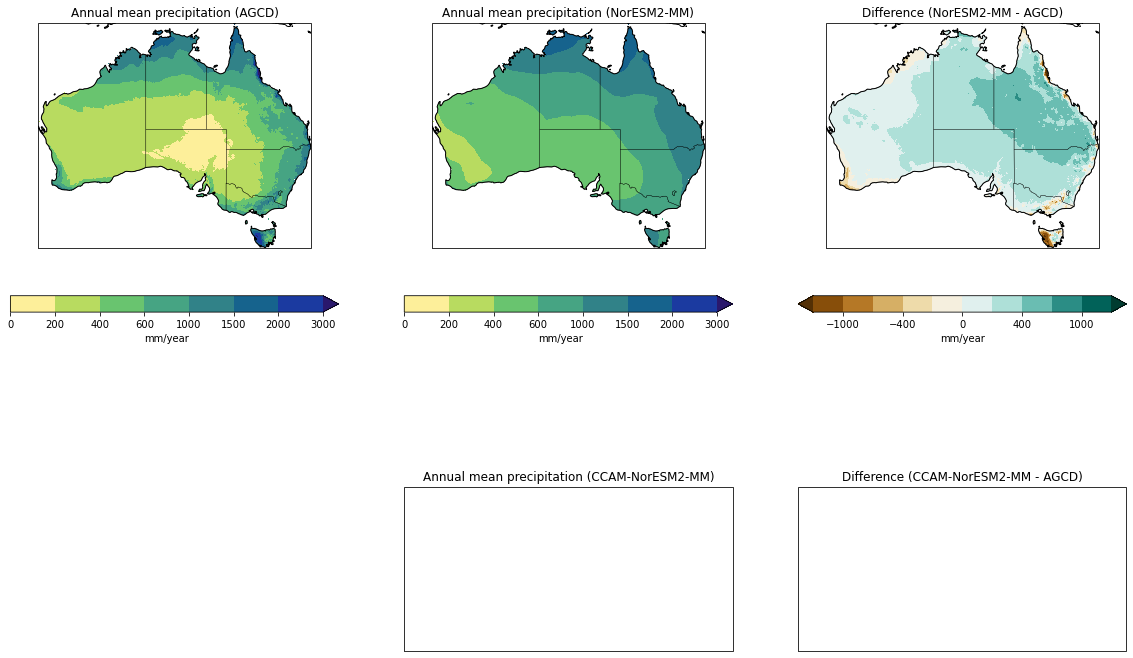

In [20]:
plot_annual_clim(
    annual_clim_dict['NorESM2-MM']['pr'],
    agcd_annual_clim['precip'],
    'NorESM2-MM',
    'CCAM'
)

/g/data/xv83/dbi599/model-evaluation/pr_annual-clim_BARPA-ACCESS-CM2_1995-01-01_2014-12-31.png


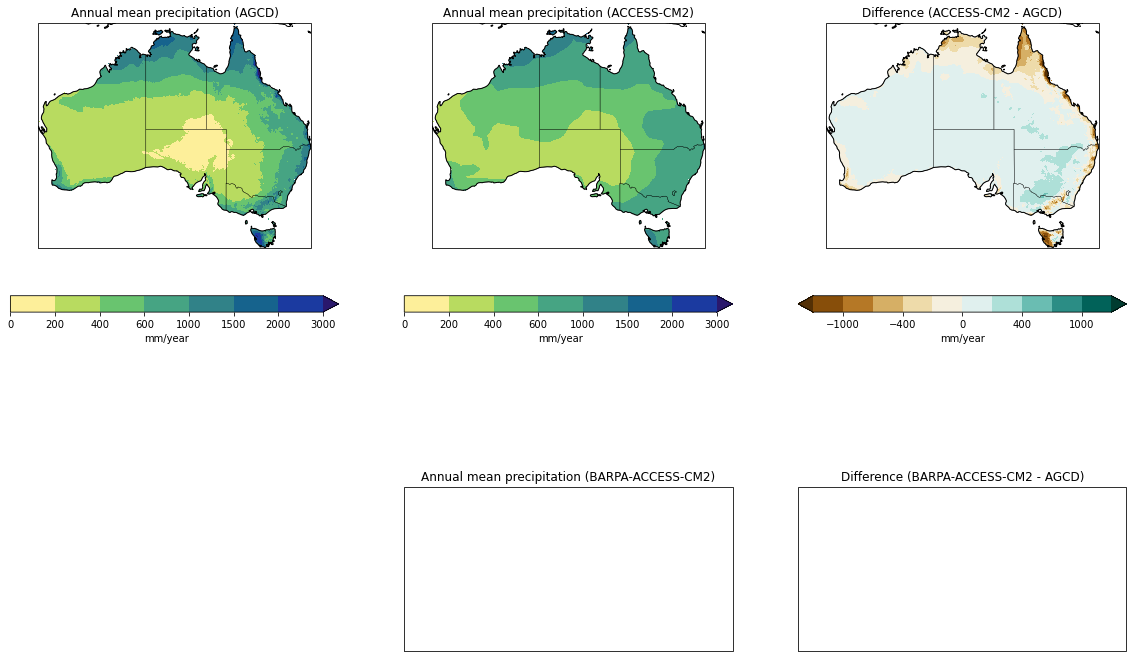

In [21]:
plot_annual_clim(
    annual_clim_dict['ACCESS-CM2']['pr'],
    agcd_annual_clim['precip'],
    'ACCESS-CM2',
    'BARPA'
)

## Temporal 

In [22]:
agcd_monthly_clim = agcd_monthly_clim.compute()

[########################################] | 100% Completed |  5.0s


In [30]:
def plot_temporal_eval(parent_monthly_clim, agcd_monthly_clim, parent_name, rcm_name):
    """Plot assessment of phase and amplitude of seasonal cycle"""

    parent_corr = xr.corr(parent_monthly_clim, agcd_monthly_clim, dim='month') 
    parent_std = parent_monthly_clim.std(dim='month', keep_attrs=True)
    agcd_std = agcd_monthly_clim.std(dim='month', keep_attrs=True)
    parent_std_ratio = parent_std / agcd_std
    
    std_ratio_levels = [0.25, 0.5, 0.67, 0.8, 1.0, 1.25, 1.5, 2.0, 4.0]
    fig = plt.figure(figsize=[14, 14])

    ax1 = fig.add_subplot(221, projection=ccrs.PlateCarree())
    parent_corr.plot(
        ax=ax1,
        transform=ccrs.PlateCarree(),
        cmap='RdBu_r',
        vmax=1,
        vmin=-1,
        cbar_kwargs = {'orientation': 'horizontal', 'label': 'corrrelation'}
    )
    ax1.set_title(f'Temporal correlation ({parent_name} vs. AGCD)')

    ax2 = fig.add_subplot(222, projection=ccrs.PlateCarree())
    parent_std_ratio.plot(
        ax=ax2,
        transform=ccrs.PlateCarree(),
        cmap='RdBu_r',
        levels=std_ratio_levels,
    extend='both',
    cbar_kwargs = {'orientation': 'horizontal', 'label': 'stdev ratio'}
    )
    ax2.set_title(f'Temporal standard deviation ratio ({parent_name} vs. AGCD)')
    
    ax3 = fig.add_subplot(223, projection=ccrs.PlateCarree())
    ax3.set_title(f'Temporal correlation ({rcm_name}-{parent_name} vs. AGCD)')

    ax4 = fig.add_subplot(224, projection=ccrs.PlateCarree())
    ax4.set_title(f'Temporal standard deviation ratio ({rcm_name}-{parent_name} vs. AGCD)')

    for ax in [ax1, ax2]:
        ax.coastlines()
        ax.add_geometries(nrm_sub_clusters.geometry, ccrs.PlateCarree(), facecolor='none', edgecolor='black')
        ax.add_feature(cartopy.feature.STATES, linewidth=0.3)
    #plt.suptitle(title)
    outfile = f'/g/data/xv83/dbi599/model-evaluation/pr_seasonal-cycle_{rcm_name}-{parent_name}_{start_date}_{end_date}.png'
    plt.savefig(outfile, bbox_inches='tight', facecolor='white', dpi=300)
    print(outfile)

/g/data/xv83/dbi599/miniconda3/envs/model-eval/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/g/data/xv83/dbi599/miniconda3/envs/model-eval/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/g/data/xv83/dbi599/miniconda3/envs/model-eval/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/g/data/xv83/dbi599/miniconda3/envs/model-eval/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


/g/data/xv83/dbi599/model-evaluation/pr_seasonal-cycle_CCAM-NorESM2-MM_1995-01-01_2014-12-31.png


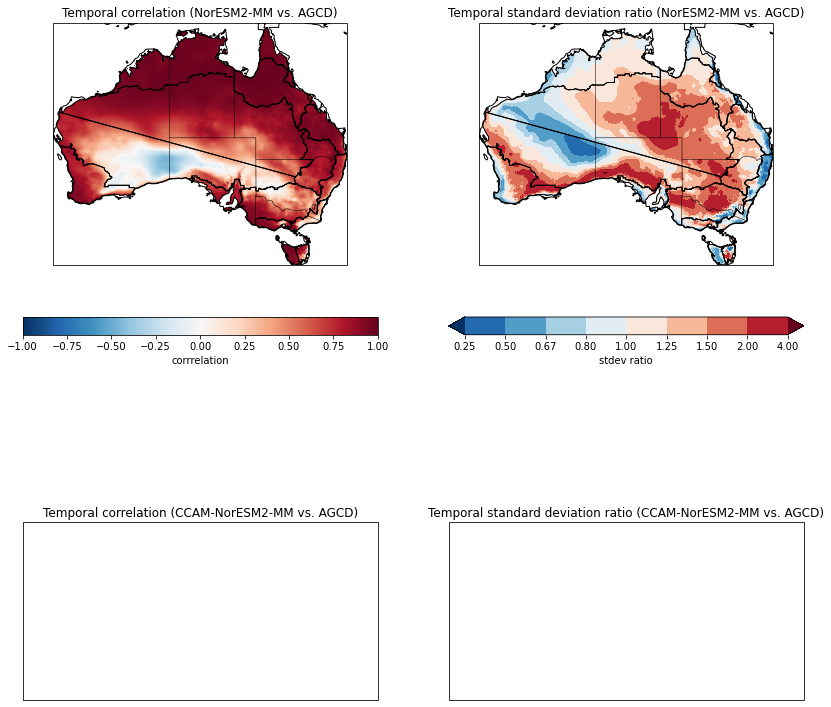

In [31]:
plot_temporal_eval(
    monthly_clim_dict['NorESM2-MM']['pr'],
    agcd_monthly_clim['precip'],
    'NorESM2-MM',
    'CCAM'
)

/g/data/xv83/dbi599/miniconda3/envs/model-eval/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/g/data/xv83/dbi599/miniconda3/envs/model-eval/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/g/data/xv83/dbi599/miniconda3/envs/model-eval/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/g/data/xv83/dbi599/miniconda3/envs/model-eval/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


/g/data/xv83/dbi599/model-evaluation/pr_seasonal-cycle_BARPA-ACCESS-CM2_1995-01-01_2014-12-31.png


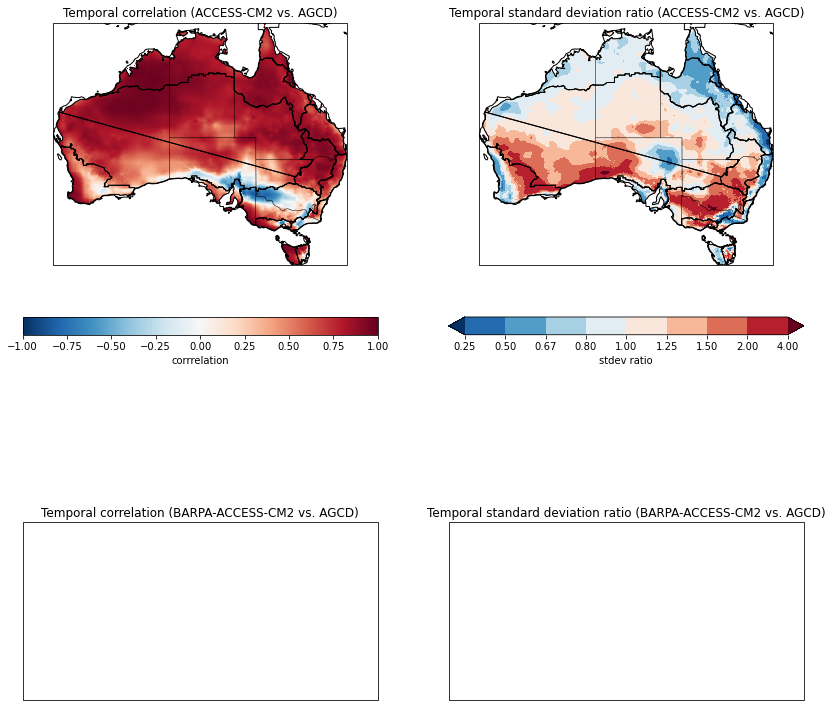

In [32]:
plot_temporal_eval(
    monthly_clim_dict['ACCESS-CM2']['pr'],
    agcd_monthly_clim['precip'],
    'ACCESS-CM2',
    'BARPA'
)

In [28]:
def plot_seasonal_cycle(parent_monthly_clim, agcd_monthly_clim, cluster_name, parent_name):
    """Plot seasonal cycle for a given NRM cluster"""
    
    if cluster_name in nrm_clusters['label'].values:
        cluster = nrm_clusters[nrm_clusters['label'] == cluster_name]
    elif cluster_name in nrm_sub_clusters['label'].values:
        cluster = nrm_sub_clusters[nrm_sub_clusters['label'] == cluster_name]
    else:
        raise ValueError(f'{cluster_name} is not valid cluster name')

    parent_cycle = spatial_selection.select_shapefile_regions(parent_monthly_clim, cluster, agg='weighted_mean')
    agcd_cycle = spatial_selection.select_shapefile_regions(agcd_monthly_clim, cluster, agg='weighted_mean')
    
    parent_cycle.plot(label=parent_name)
    agcd_cycle.plot(label='AGCD')
    xticks = np.arange(1,13)
    xlabels = [calendar.month_abbr[i] for i in xticks]
    plt.xticks(xticks, xlabels)
    plt.legend()
    plt.ylabel('average precipitation (mm/month)')
    plt.title(cluster_name)
    plt.show()

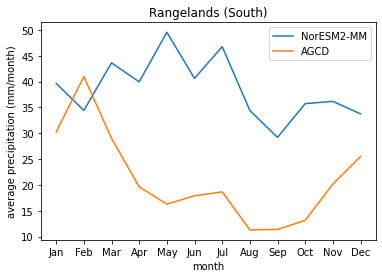

In [29]:
plot_seasonal_cycle(
    monthly_clim_dict['NorESM2-MM']['pr'],
    agcd_monthly_clim['precip'],
    'Rangelands (South)',
    'NorESM2-MM',
)

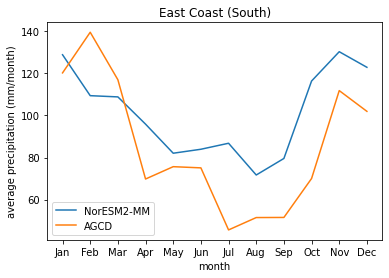

In [33]:
plot_seasonal_cycle(
    monthly_clim_dict['NorESM2-MM']['pr'],
    agcd_monthly_clim['precip'],
    'East Coast (South)',
    'NorESM2-MM',
)

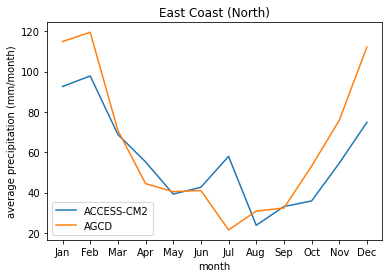

In [34]:
plot_seasonal_cycle(
    monthly_clim_dict['ACCESS-CM2']['pr'],
    agcd_monthly_clim['precip'],
    'East Coast (North)',
    'ACCESS-CM2',
)